In [1]:
%load_ext autoreload
%autoreload 2

here the objective is to fit the logit graph model to multiple different graph domains and then visualize the original vs fitted graphs

In [2]:

import sys
import os
sys.path.append('../..')

#Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [3]:
FOLDER_OUTPUT = f'runs/fitted_graphs_comparison_hamsterster'
out_files = os.listdir(FOLDER_OUTPUT)
out_files = sorted(out_files, key=lambda x: os.path.getctime(os.path.join(FOLDER_OUTPUT, x)), reverse=True)

out_files

['comparators_soc-hamsterster.pkl']

In [4]:
import pickle
#pick first id from out_files
id = out_files[0]

with open(f'{FOLDER_OUTPUT}/{id}', 'rb') as f:
    comparators = pickle.load(f)


In [5]:
len(comparators)

1

In [6]:
dfs = []
for i in range(len(comparators)):
    dfs.append(comparators[i].summary_df)

dfs[0]

graph_filename     model  gic_value               param  \
0  soc-hamsterster.edges  Original        NaN                 N/A   
1  soc-hamsterster.edges        LG   0.462624  d=1, sigma=-6.2713   
2  soc-hamsterster.edges        WS   0.750981                20.2   
3  soc-hamsterster.edges        BA   1.783021                 5.0   
4  soc-hamsterster.edges        ER   3.988882                0.01   
5  soc-hamsterster.edges       GRG   9.321434                 1.0   

   fit_success  nodes    edges   density  avg_clustering  avg_path_length  \
0         True   2426    16630  0.005654        0.537533         3.588995   
1         True   2426     3794  0.001290        0.000582         6.718709   
2         True   2426    16982  0.005773        0.005244         3.246346   
3         True   2426    12105  0.004115        0.023393         3.227577   
4         True   2426    29309  0.009964        0.010331         2.775620   
5         True   2426  2863999  0.973644        0.977015         1.026356   

   diameter  assortativity  num_components  largest_component_size  
0        10       0.047401             148                    2000  
1        15       0.003328             134                    2287  
2         5      -0.045362               1                    2426  
3         5      -0.044367               1                    2426  
4         4       0.007409               1                    2426  
5         2      -0.034602               1                    2426

In [7]:
pd.concat(dfs)

graph_filename     model  gic_value               param  \
0  soc-hamsterster.edges  Original        NaN                 N/A   
1  soc-hamsterster.edges        LG   0.462624  d=1, sigma=-6.2713   
2  soc-hamsterster.edges        WS   0.750981                20.2   
3  soc-hamsterster.edges        BA   1.783021                 5.0   
4  soc-hamsterster.edges        ER   3.988882                0.01   
5  soc-hamsterster.edges       GRG   9.321434                 1.0   

   fit_success  nodes    edges   density  avg_clustering  avg_path_length  \
0         True   2426    16630  0.005654        0.537533         3.588995   
1         True   2426     3794  0.001290        0.000582         6.718709   
2         True   2426    16982  0.005773        0.005244         3.246346   
3         True   2426    12105  0.004115        0.023393         3.227577   
4         True   2426    29309  0.009964        0.010331         2.775620   
5         True   2426  2863999  0.973644        0.977015         1.026356   

   diameter  assortativity  num_components  largest_component_size  
0        10       0.047401             148                    2000  
1        15       0.003328             134                    2287  
2         5      -0.045362               1                    2426  
3         5      -0.044367               1                    2426  
4         4       0.007409               1                    2426  
5         2      -0.034602               1                    2426

In [8]:
# Create a dictionary to store rankings for each graph
rankings = {}

# Go through each df in dfs
for df in dfs:
    graph_name = df['graph_filename'].iloc[0]  # Get graph filename
    
    # Sort models by GIC value (excluding 'Original' which has NaN GIC)
    model_ranks = df[df['model'] != 'Original'].sort_values('gic_value')['model'].tolist()
    
    # Create rankings dictionary for this graph (1 is best since lowest GIC is best)
    rankings[graph_name] = {model: rank+1 for rank, model in enumerate(model_ranks)}

# Get unique models (excluding 'Original')
models = sorted(list(set([model for df in dfs for model in df['model'].unique() if model != 'Original'])))

# Create DataFrame with rankings
ranking_df = pd.DataFrame(rankings).T

# Ensure all models are present as columns
for model in models:
    if model not in ranking_df.columns:
        ranking_df[model] = np.nan

# Keep only the model columns in a consistent order
ranking_df = ranking_df[models]

print("Rankings by GIC value (lower is better):")
print(ranking_df)


Rankings by GIC value (lower is better):
                       BA  ER  GRG  LG  WS
soc-hamsterster.edges   3   4    5   1   2


In [9]:
ranking_df.mean(axis=0)

BA     3.0
ER     4.0
GRG    5.0
LG     1.0
WS     2.0
dtype: float64

# More plots

In [10]:
def find_comparator_for_connectome(connectome_name):
    for comparator in comparators:
        if comparator.summary_df['graph_filename'].iloc[0] == connectome_name:
            return comparator
    return None

In [15]:
def find_comparator_for_connectome(connectome_name):
    for comparator in comparators:
        if comparator.summary_df['graph_filename'].iloc[0] == connectome_name:
            return comparator
    return None



graph = comparators[0]
graph_name = graph.summary_df['graph_filename'].iloc[0]
graph_name = graph_name.replace('.graphml', '')
print(graph_name)

#graph = find_comparator_for_connectome('rhesus_cerebral.cortex_1.graphml')

soc-hamsterster.edges


In [16]:
os.makedirs(f'imgs', exist_ok=True)

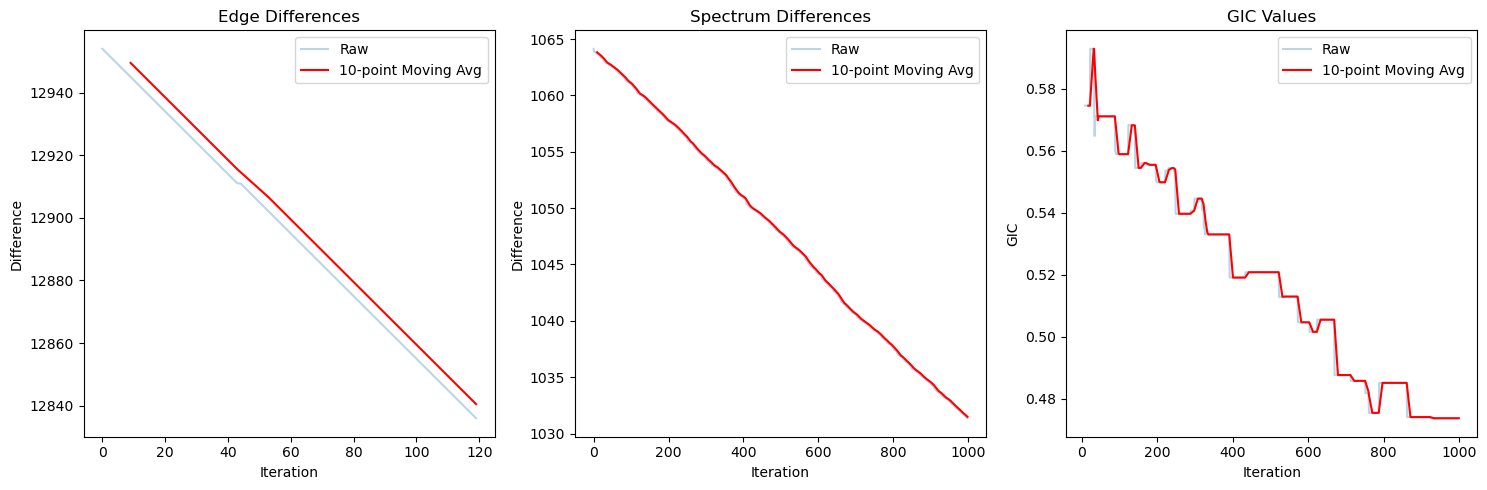

In [17]:
spec_diff = graph.fitted_graphs_data['LG']['metadata']['spectrum_diffs']
edge_diff = graph.fitted_graphs_data['LG']['metadata']['edge_diffs']
gic_values = graph.fitted_graphs_data['LG']['metadata']['gic_values']

# Calculate moving averages with window size of 10
window = 10
edge_diff_ma = pd.Series(edge_diff).rolling(window=window).mean()
spec_diff_ma = pd.Series(spec_diff).rolling(window=window).mean()
gic_values_ma = pd.Series(gic_values).rolling(window=window).mean()

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(edge_diff, alpha=0.3, label='Raw')
plt.plot(edge_diff_ma, 'r-', label=f'{window}-point Moving Avg')
plt.title('Edge Differences')
plt.xlabel('Iteration')
plt.ylabel('Difference')
plt.legend()

plt.subplot(1,3,2)
plt.plot(spec_diff, alpha=0.3, label='Raw')
plt.plot(spec_diff_ma, 'r-', label=f'{window}-point Moving Avg')
plt.title('Spectrum Differences')
plt.xlabel('Iteration')
plt.ylabel('Difference')
plt.legend()

plt.subplot(1,3,3)
plt.plot(gic_values, alpha=0.3, label='Raw')
plt.plot(gic_values_ma, 'r-', label=f'{window}-point Moving Avg')
plt.title('GIC Values')
plt.xlabel('Iteration')
plt.ylabel('GIC')
plt.legend()

plt.tight_layout()

# Save the figure
plt.savefig(f'imgs/{graph_name}_iteration.png', bbox_inches='tight', dpi=300)

plt.show()

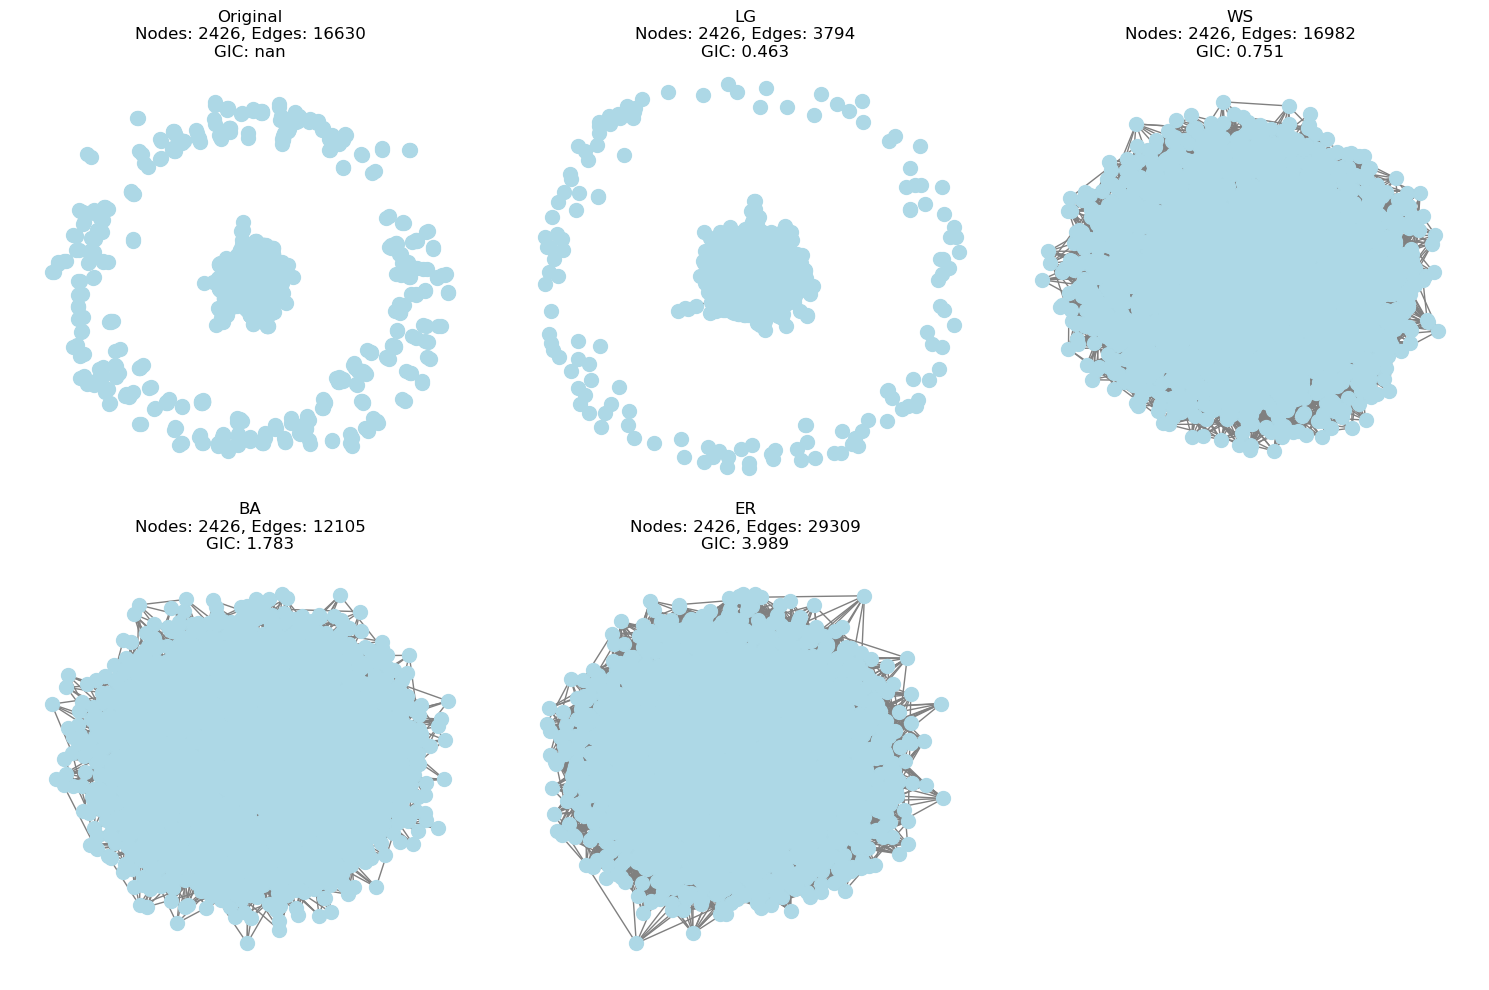

In [18]:
# Get the graph data for each model
graph_data = graph.fitted_graphs_data

# Create a figure with subplots for each model
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot each graph
for i, (model, data) in enumerate(graph_data.items()):
    graph2 = data['graph']
    pos = nx.spring_layout(graph2, seed=42)
    
    nx.draw(graph2, pos, ax=axes[i], 
            node_size=100,
            node_color='lightblue',
            edge_color='gray',
            with_labels=False)
    
    # Add title with model name and key metrics
    attrs = data['attributes']
    gic = data['metadata'].get('gic_value', 'N/A')
    title = f"{model}\n"
    title += f"Nodes: {attrs['nodes']}, Edges: {attrs['edges']}\n"
    # title += f"Density: {attrs['density']:.2f}\n"
    # title += f"Avg Clustering: {attrs['avg_clustering']:.2f}\n"
    title += f"GIC: {gic:.3f}" if isinstance(gic, float) else f"GIC: {gic}"
    axes[i].set_title(title)

# Remove extra subplot
axes[-1].remove()

plt.tight_layout()

# Save the figure
plt.savefig(f'imgs/{graph_name}_graph.png', bbox_inches='tight', dpi=300)

plt.show()

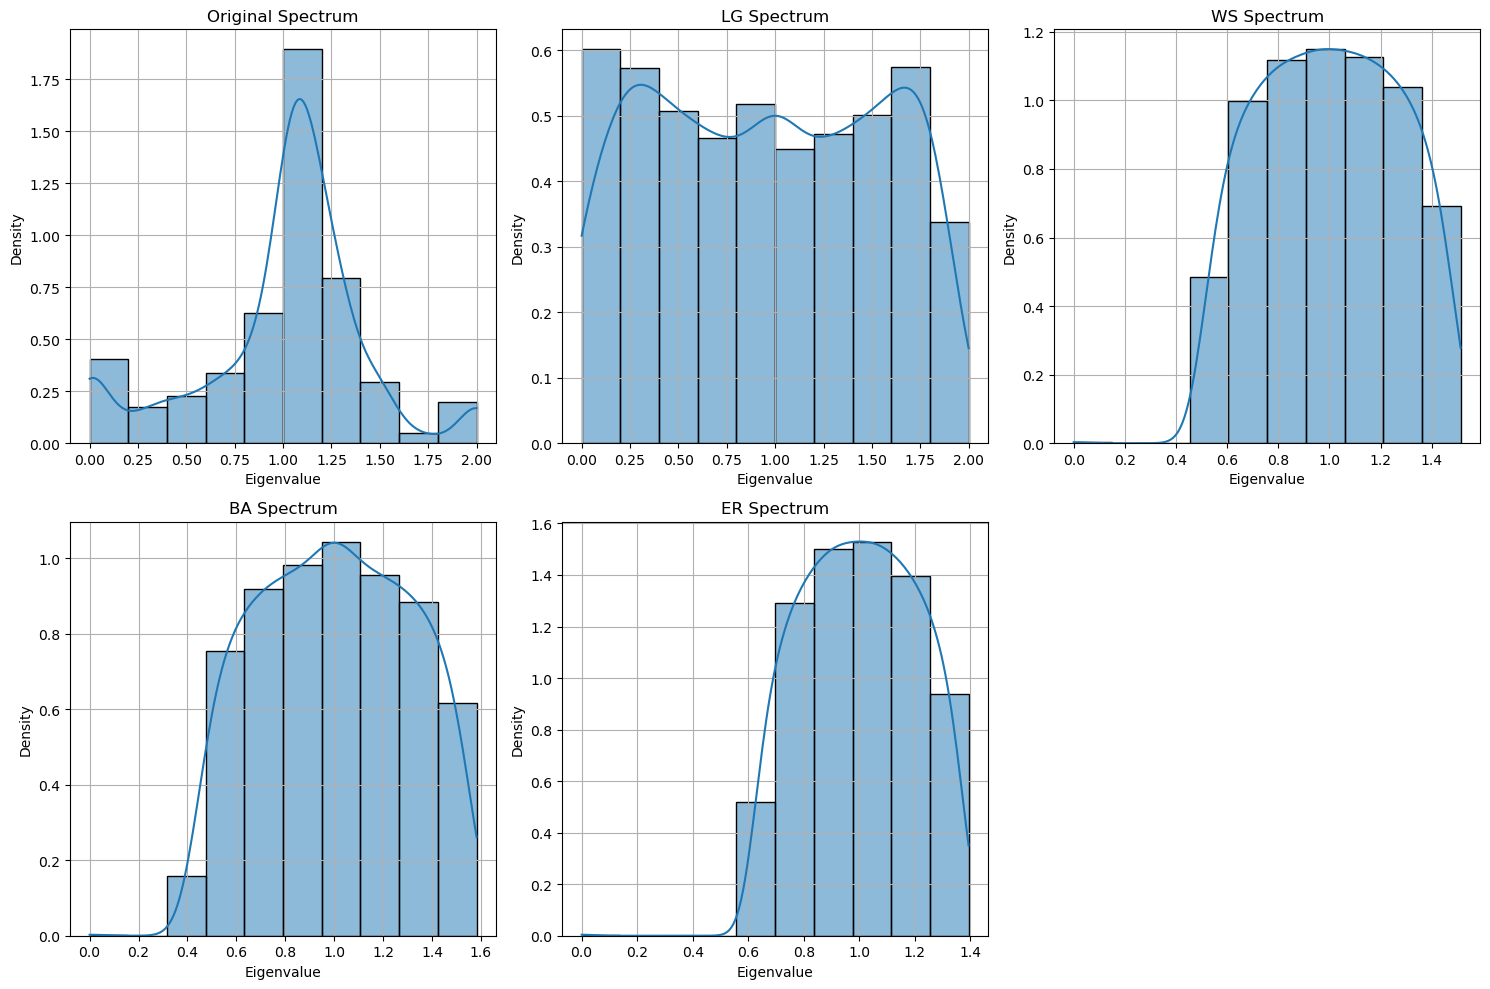

In [19]:
# Get the graph data for each model
graph_data = graph.fitted_graphs_data

# Create a figure with subplots for each model
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot spectrum for each graph
for i, (model, data) in enumerate(graph_data.items()):
    graph = data['graph']
    
    try:
        # Calculate eigenvalues
        L = nx.normalized_laplacian_matrix(graph)
        eigenvalues = np.linalg.eigvals(L.toarray())
        eigenvalues = np.real(eigenvalues)  # Get real parts
        
        # Plot histogram and KDE with reduced number of bins
        sns.histplot(data=eigenvalues, kde=True, ax=axes[i], stat='density', bins=10)
        axes[i].set_title(f"{model} Spectrum")
        axes[i].set_xlabel("Eigenvalue")
        axes[i].set_ylabel("Density")
        axes[i].grid(True)
    except MemoryError:
        axes[i].text(0.5, 0.5, "Memory Error", ha='center', va='center')
        axes[i].set_title(f"{model} Spectrum (Failed)")

# Remove extra subplot
axes[-1].remove()

plt.tight_layout()

# Save the figure
plt.savefig(f'imgs/{graph_name}_spectrum.png', bbox_inches='tight', dpi=300)

plt.show()

# Gen all plots

mouse_visual.cortex_1


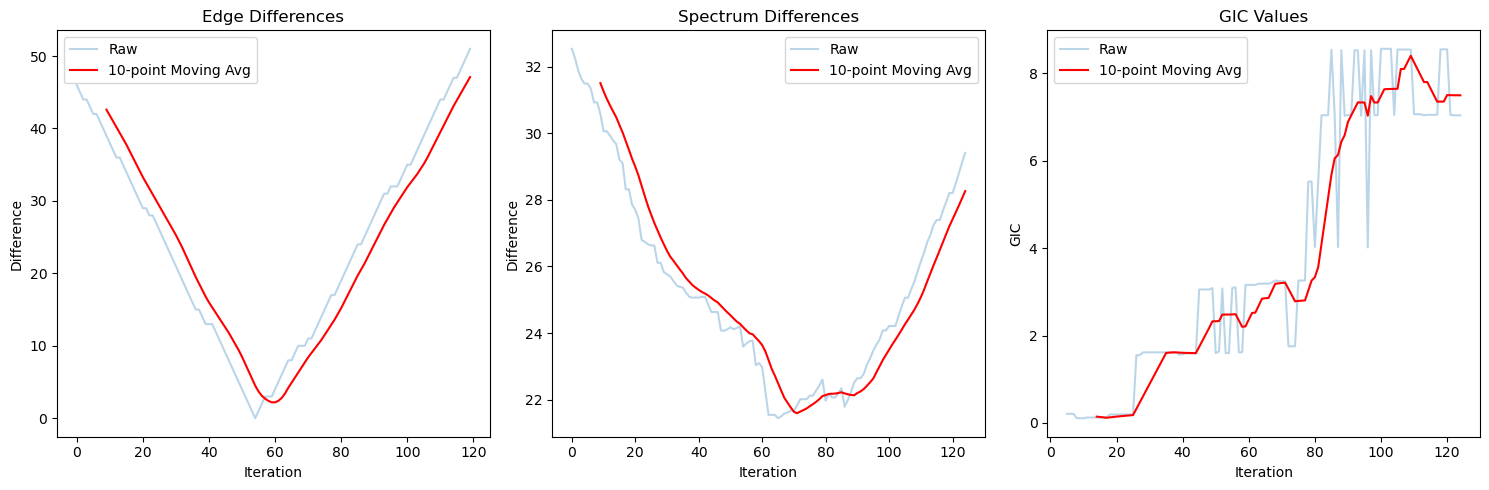

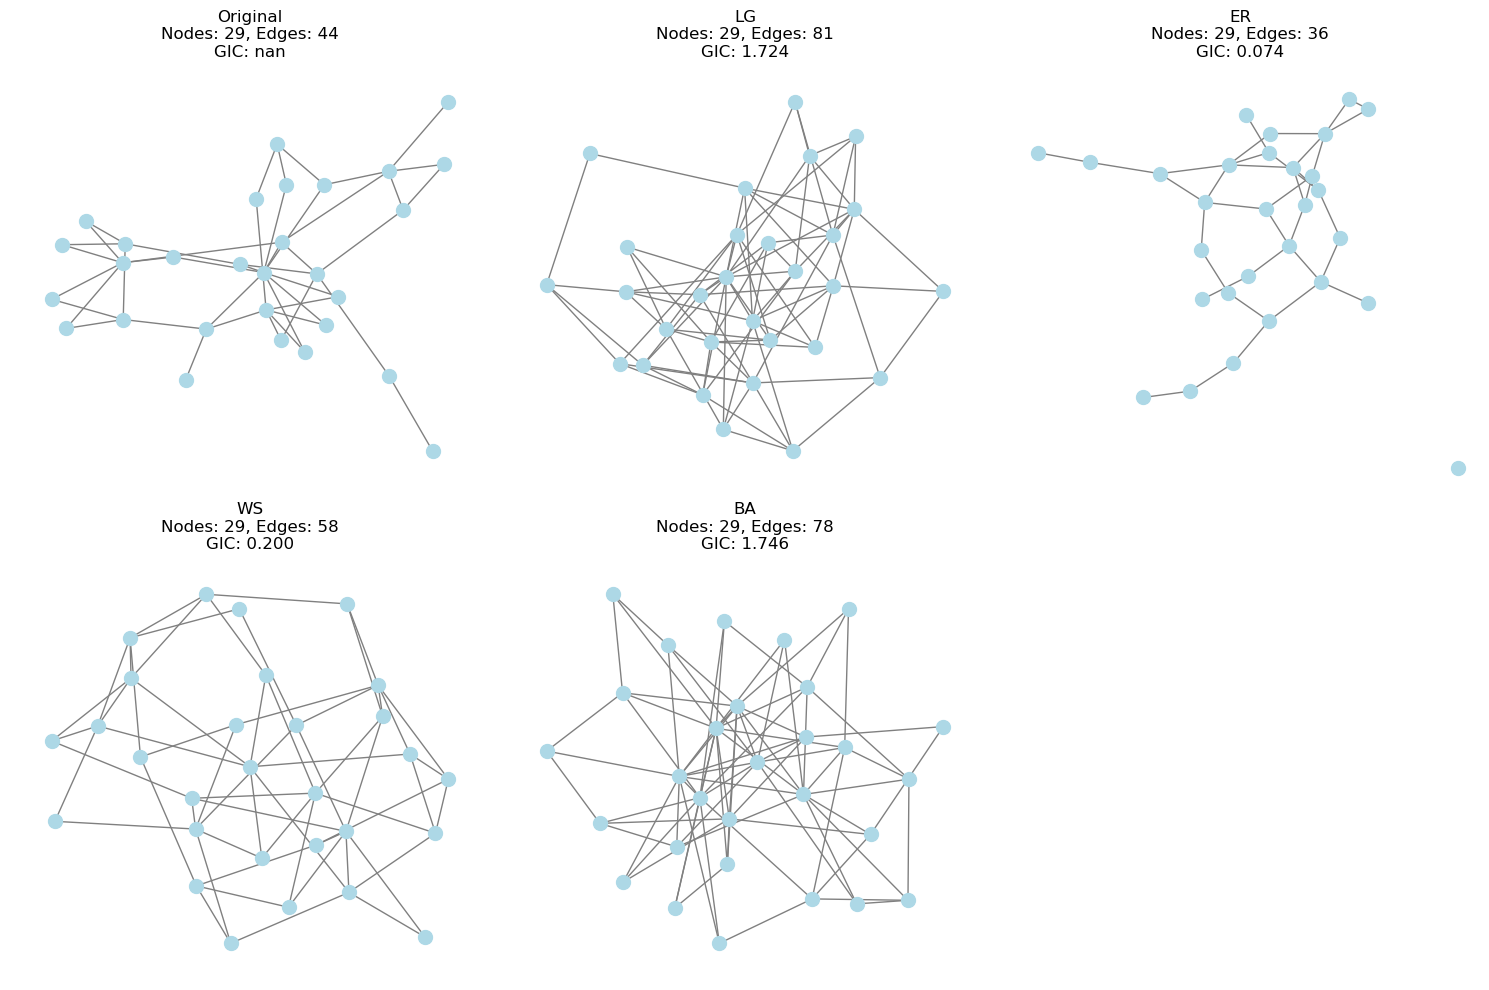

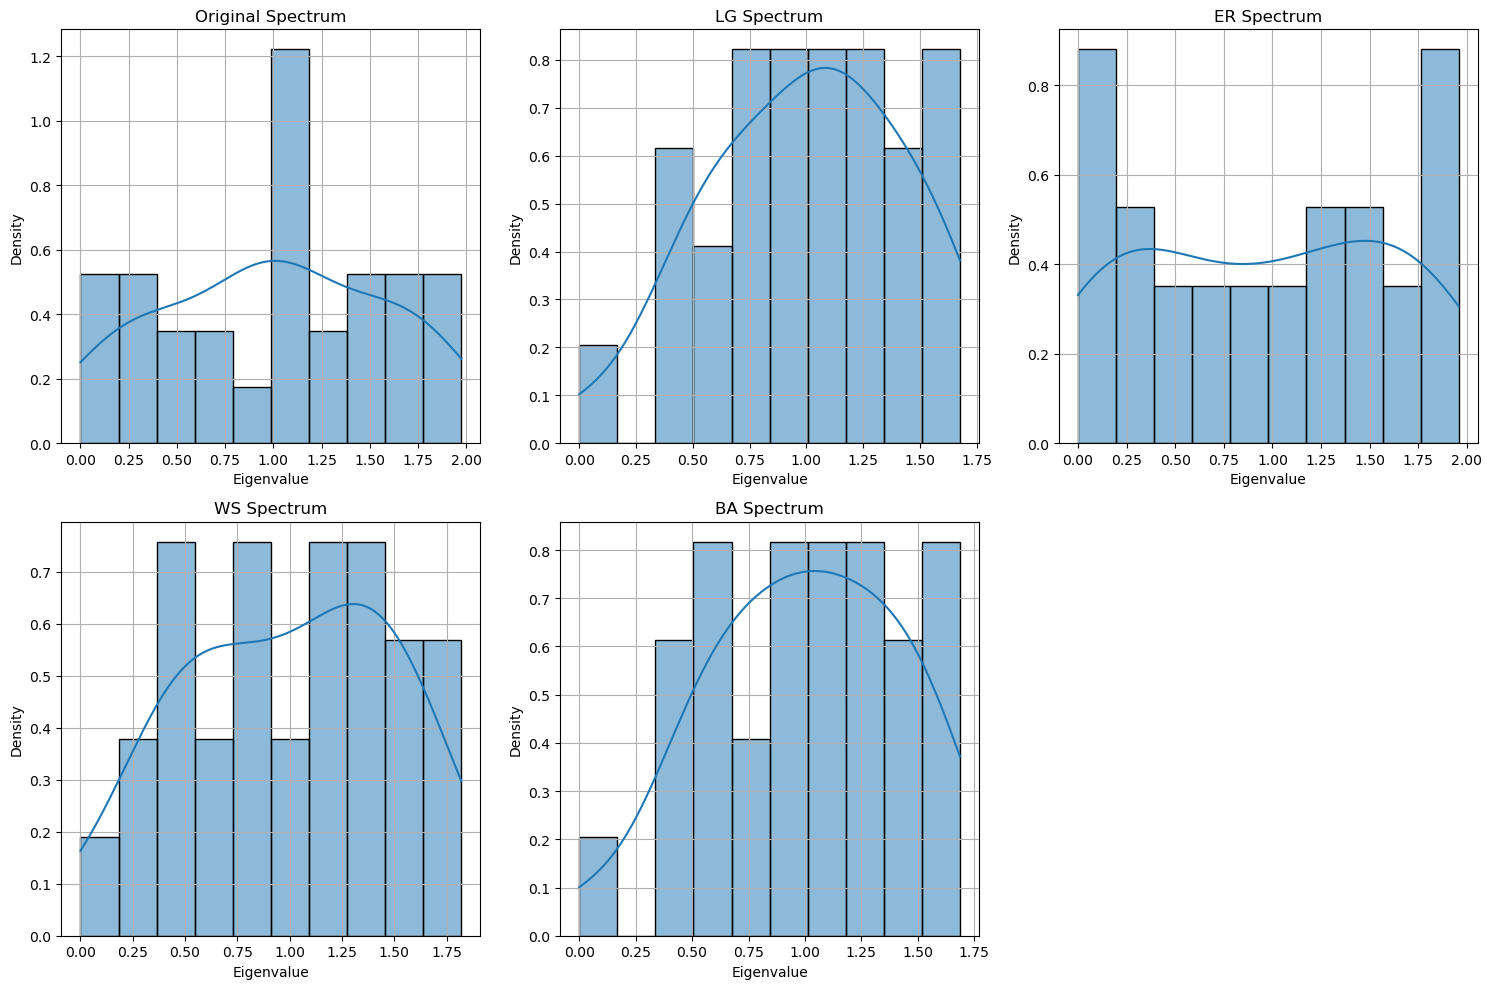

p.pacificus_neural.synaptic_2


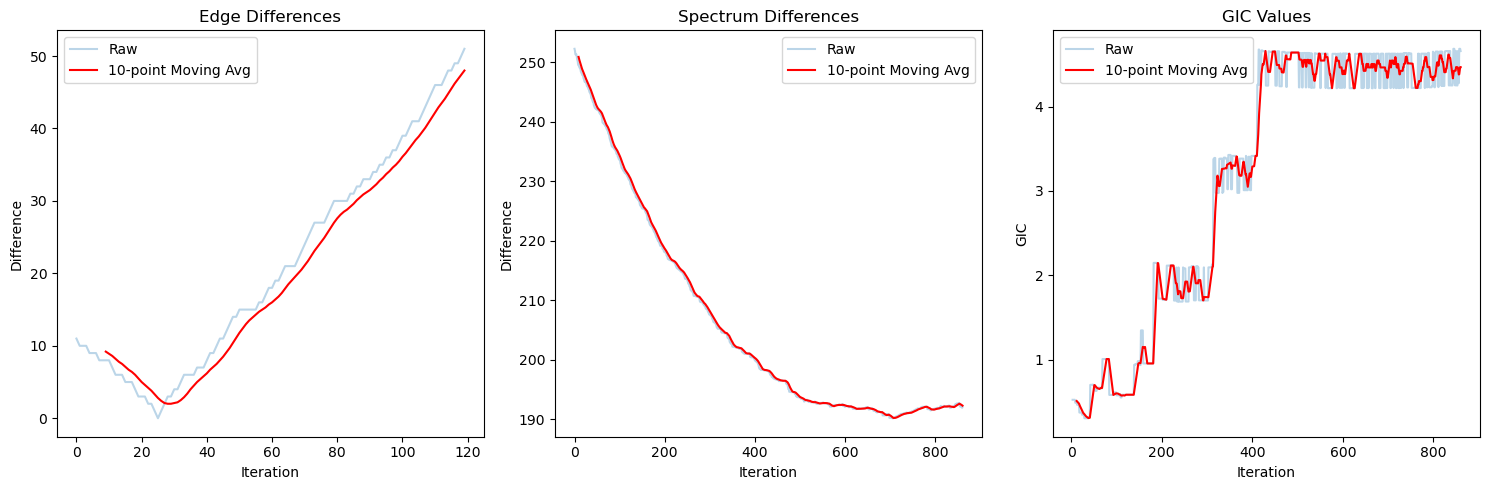

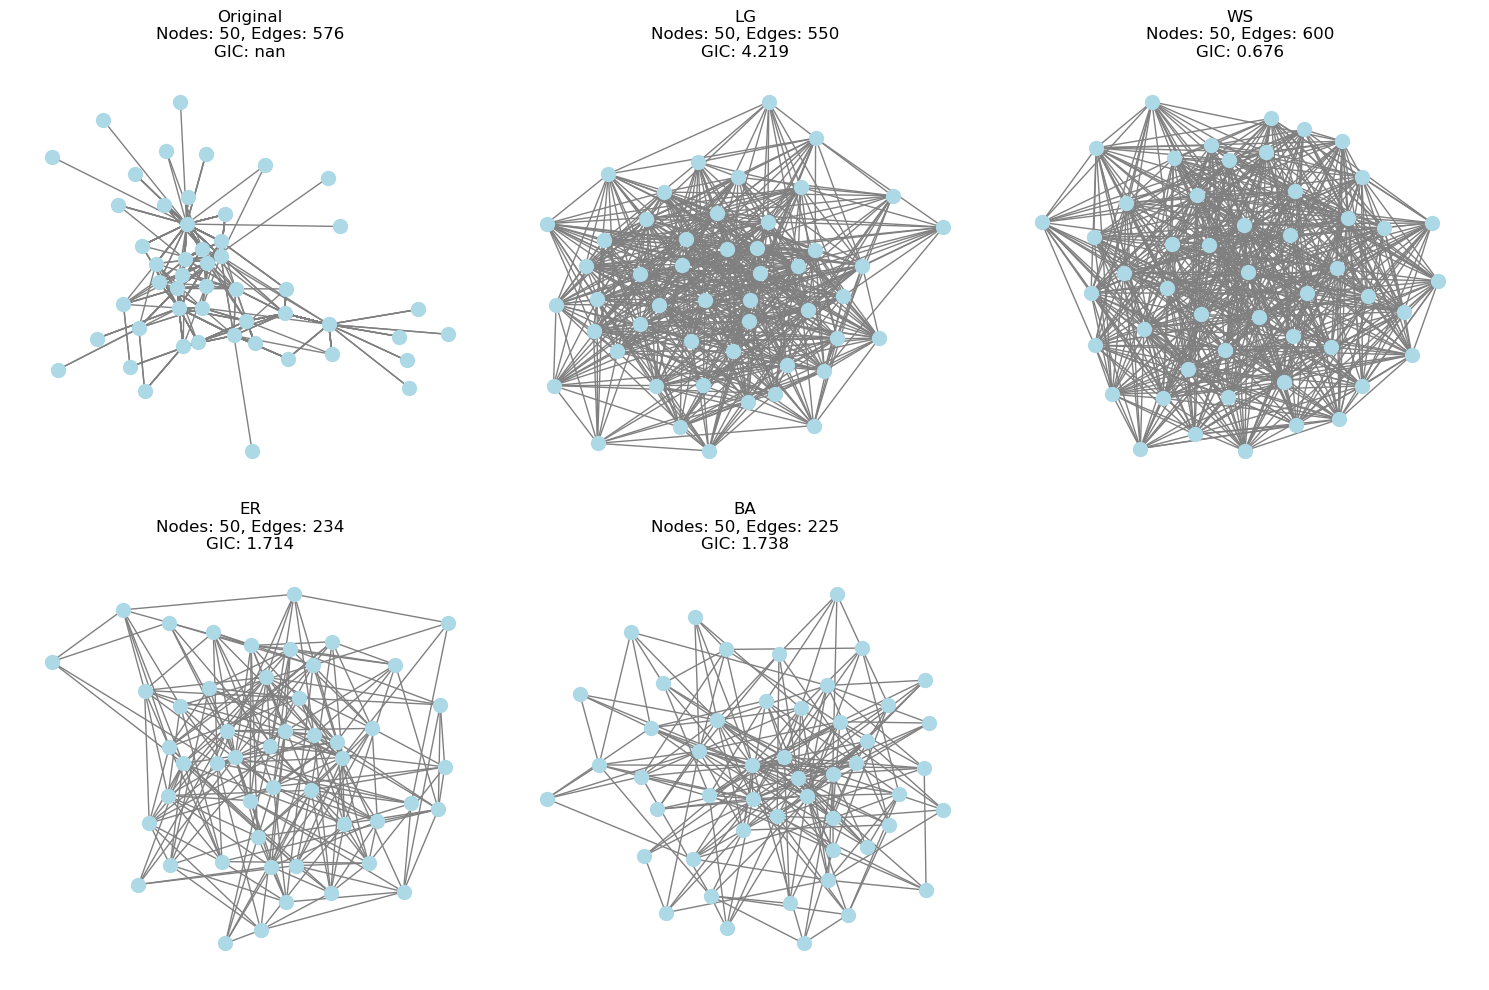

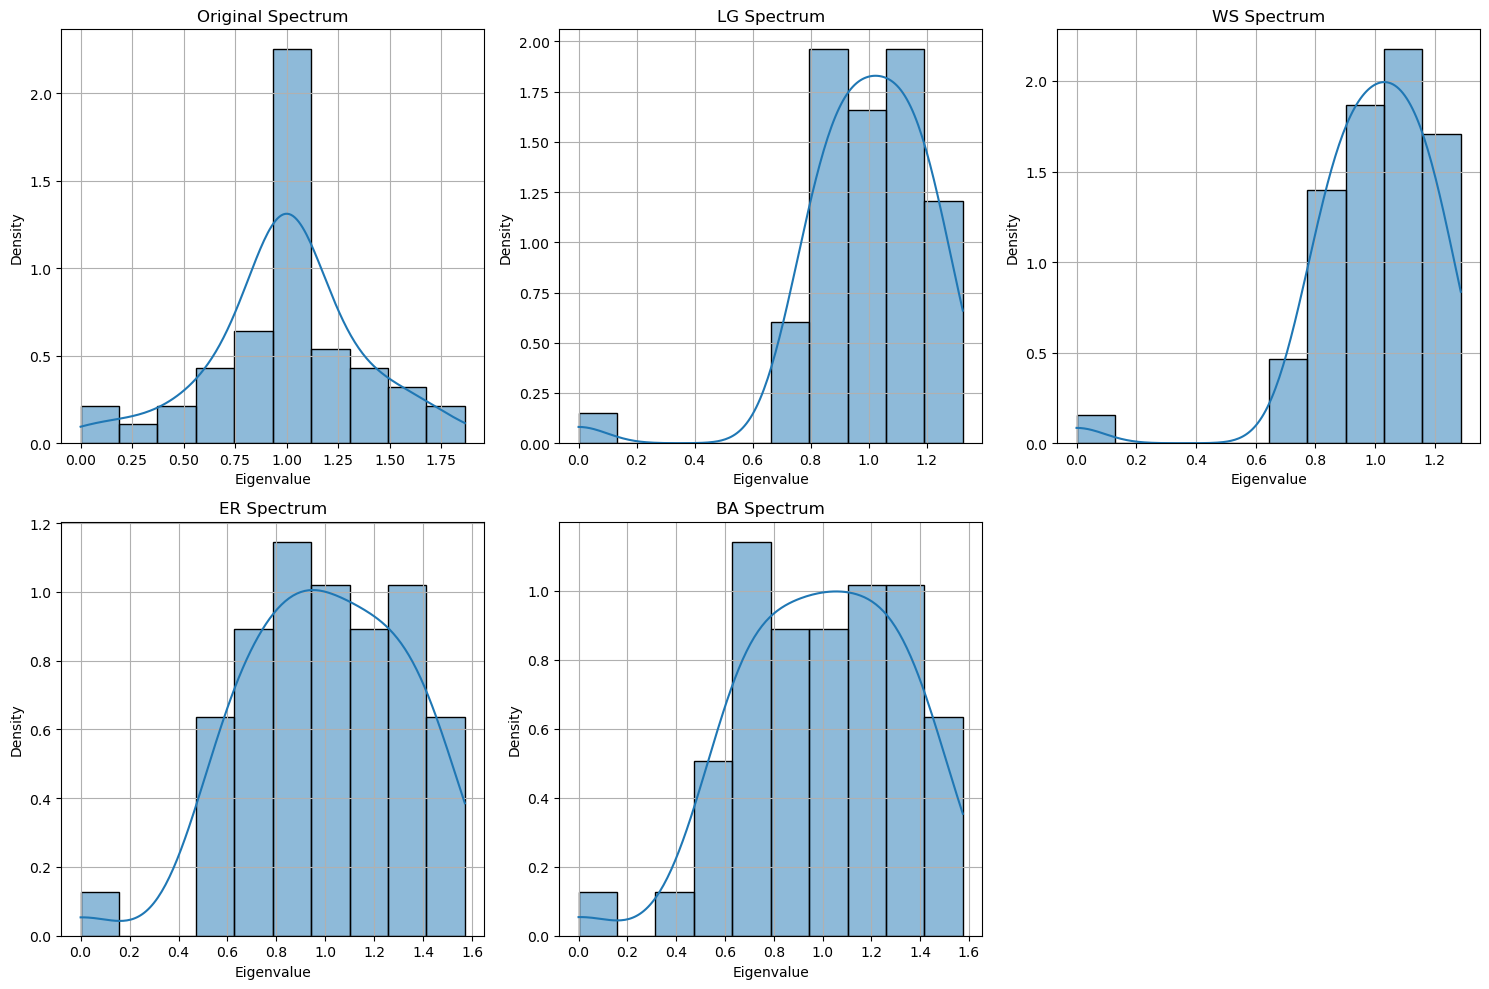

p.pacificus_neural.synaptic_1


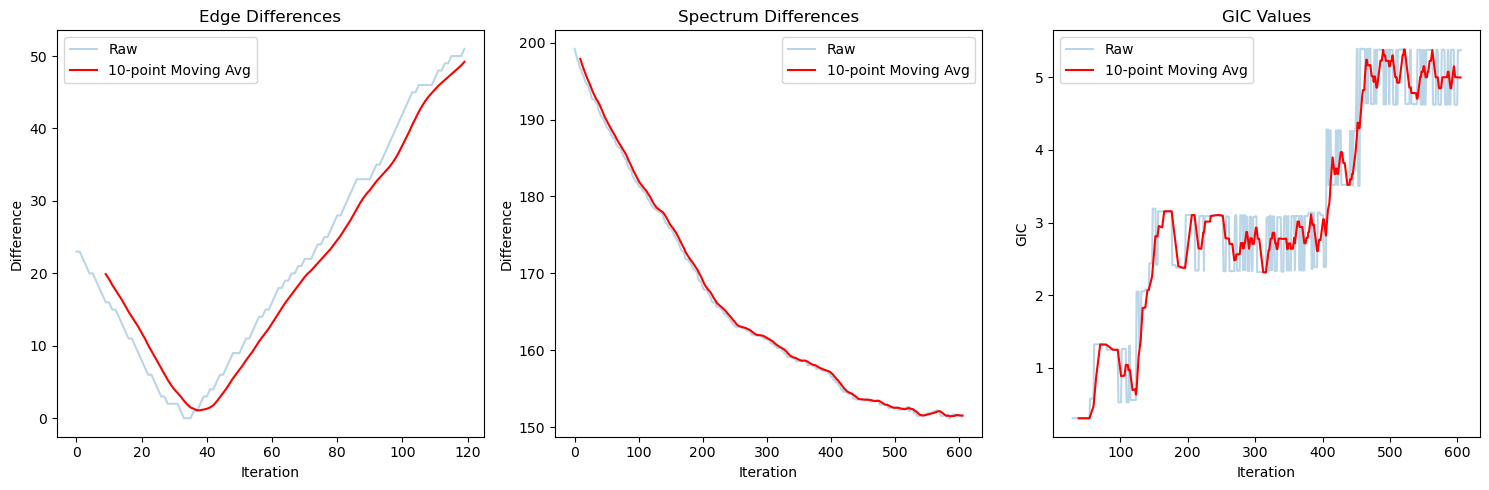

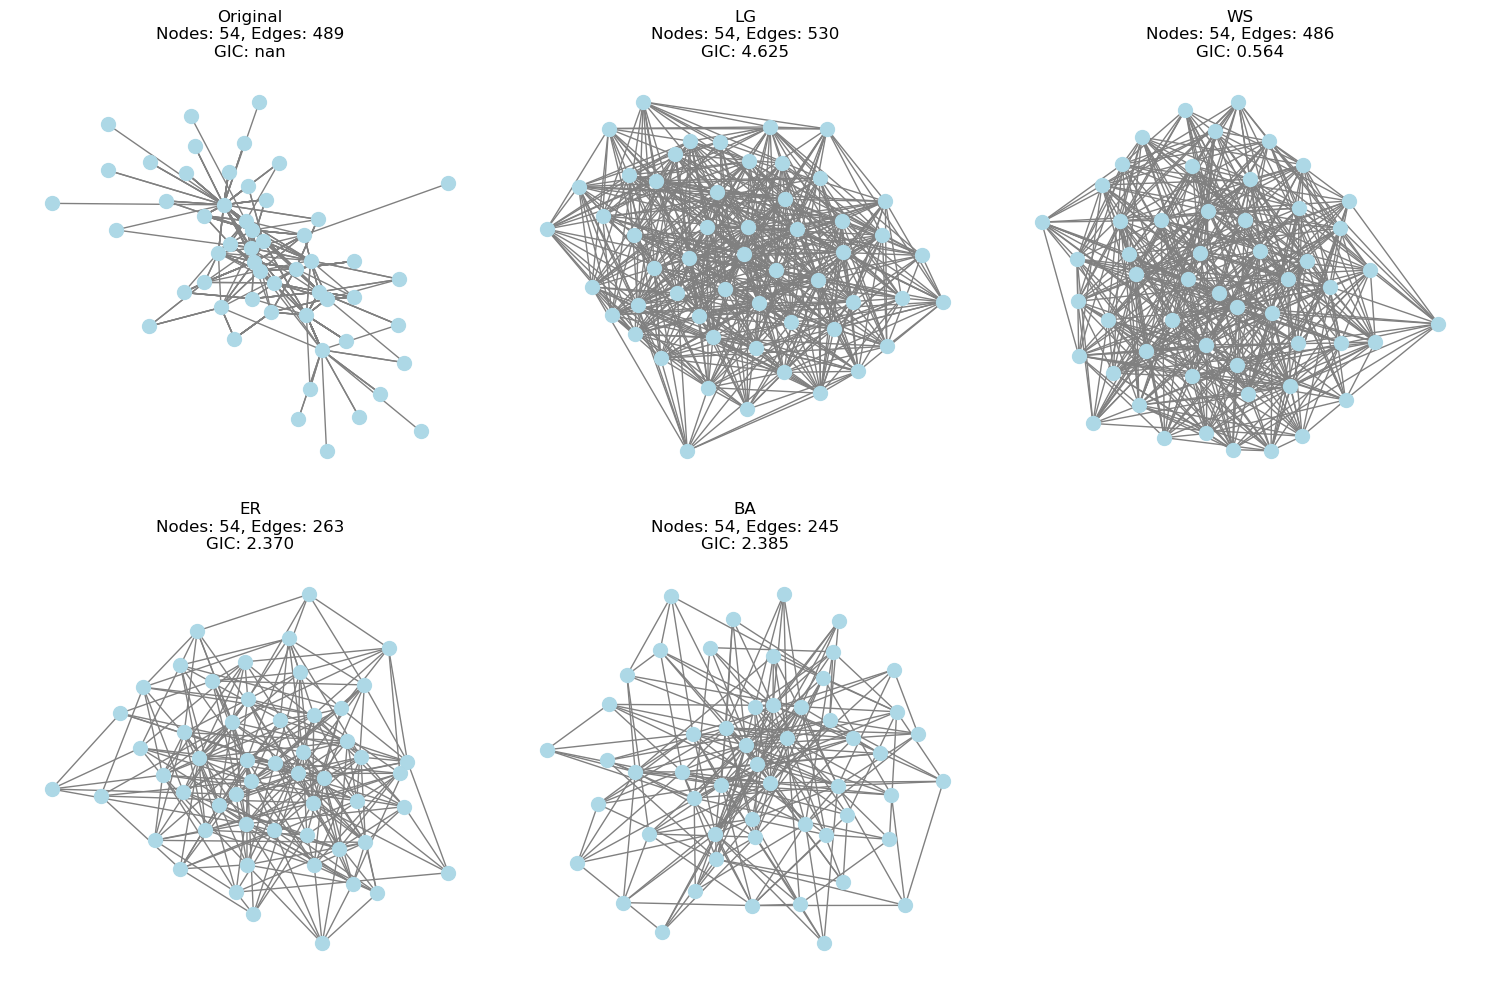

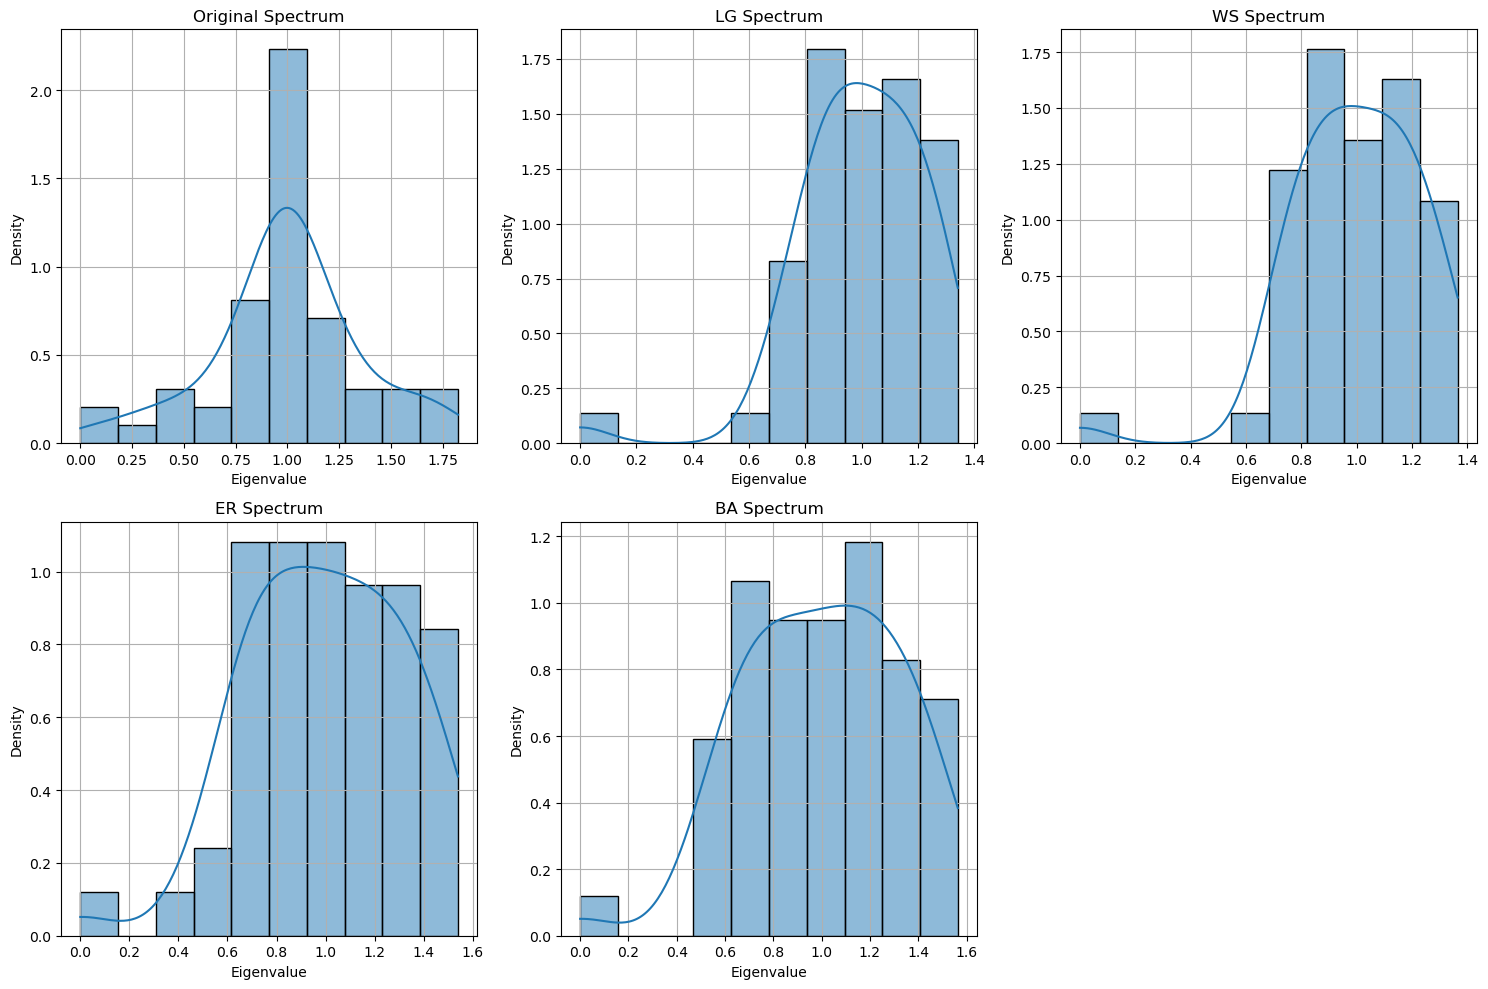

mixed.species_brain_1


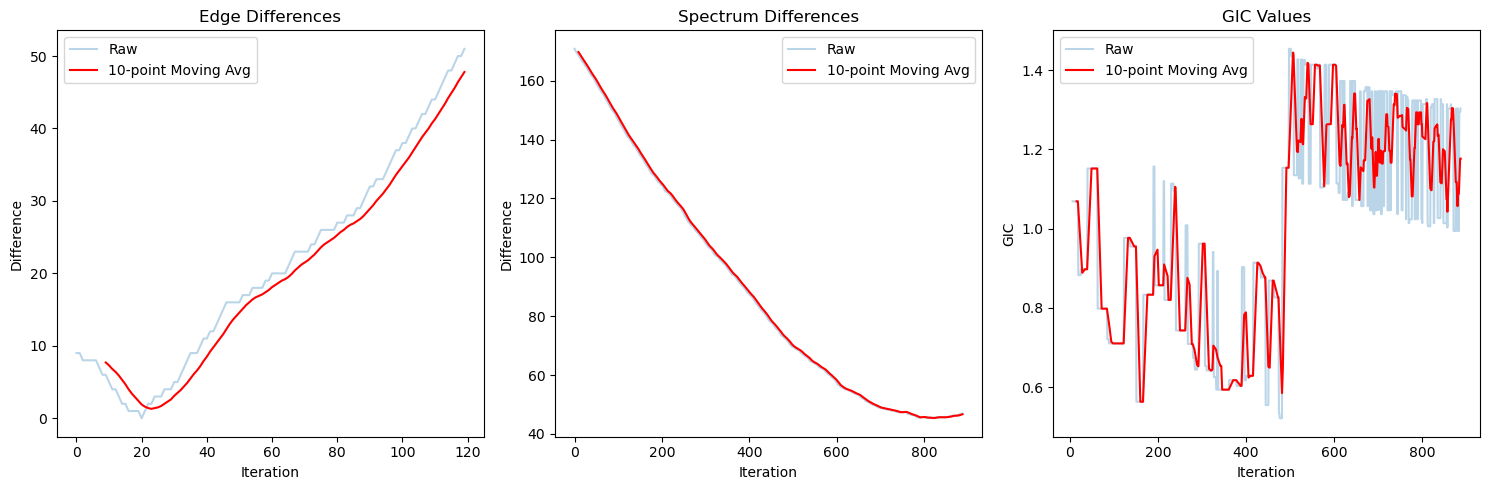

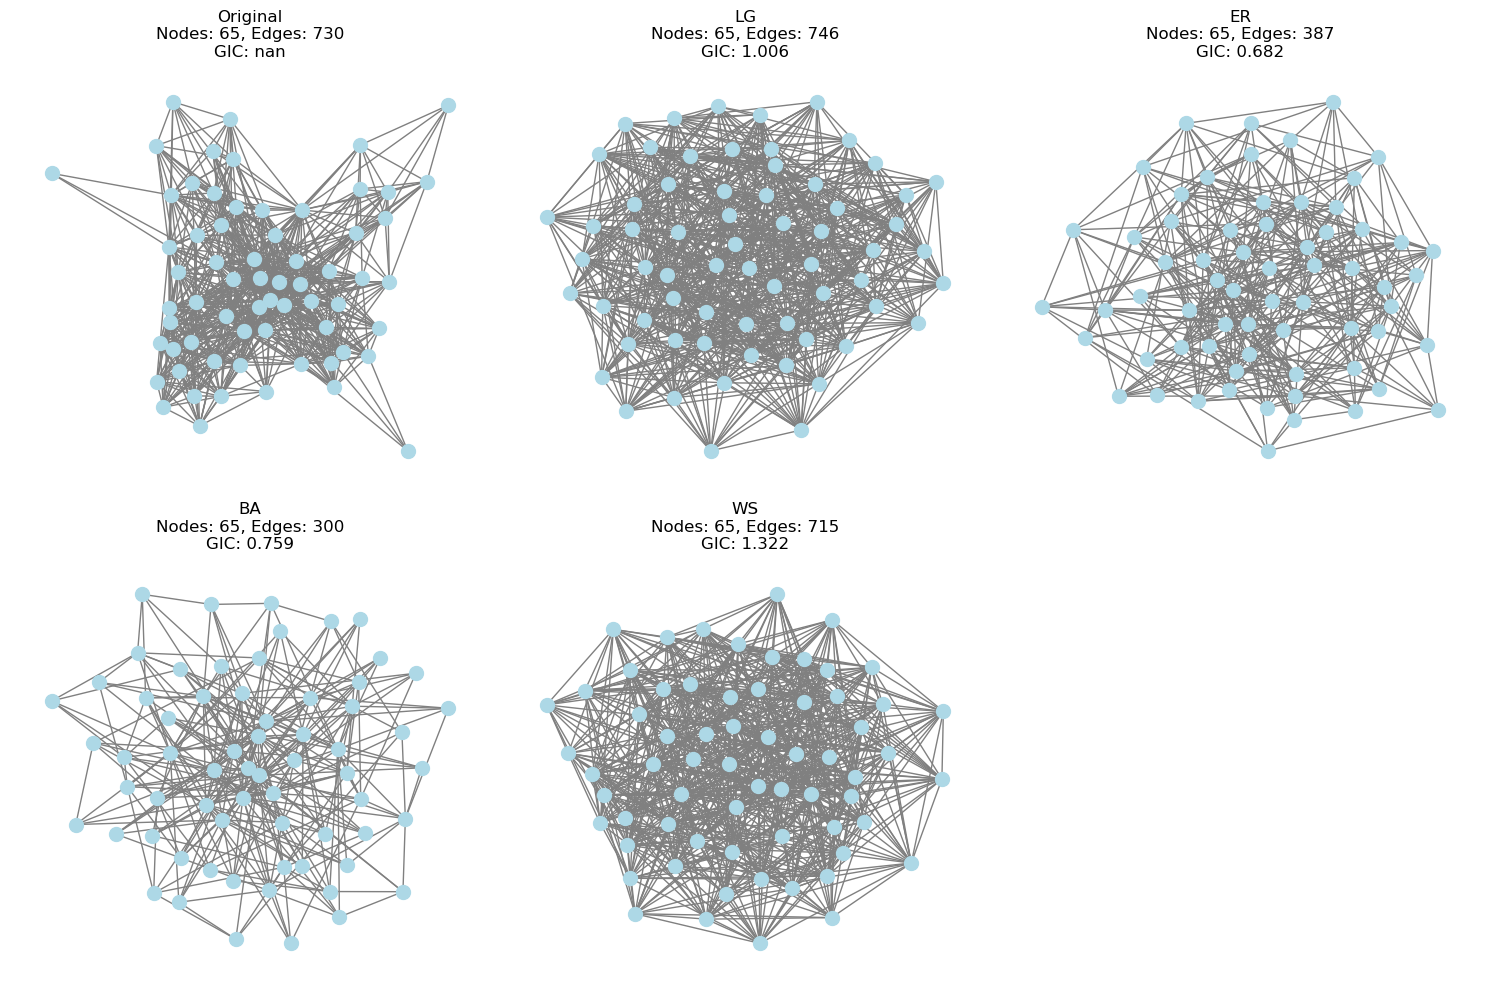

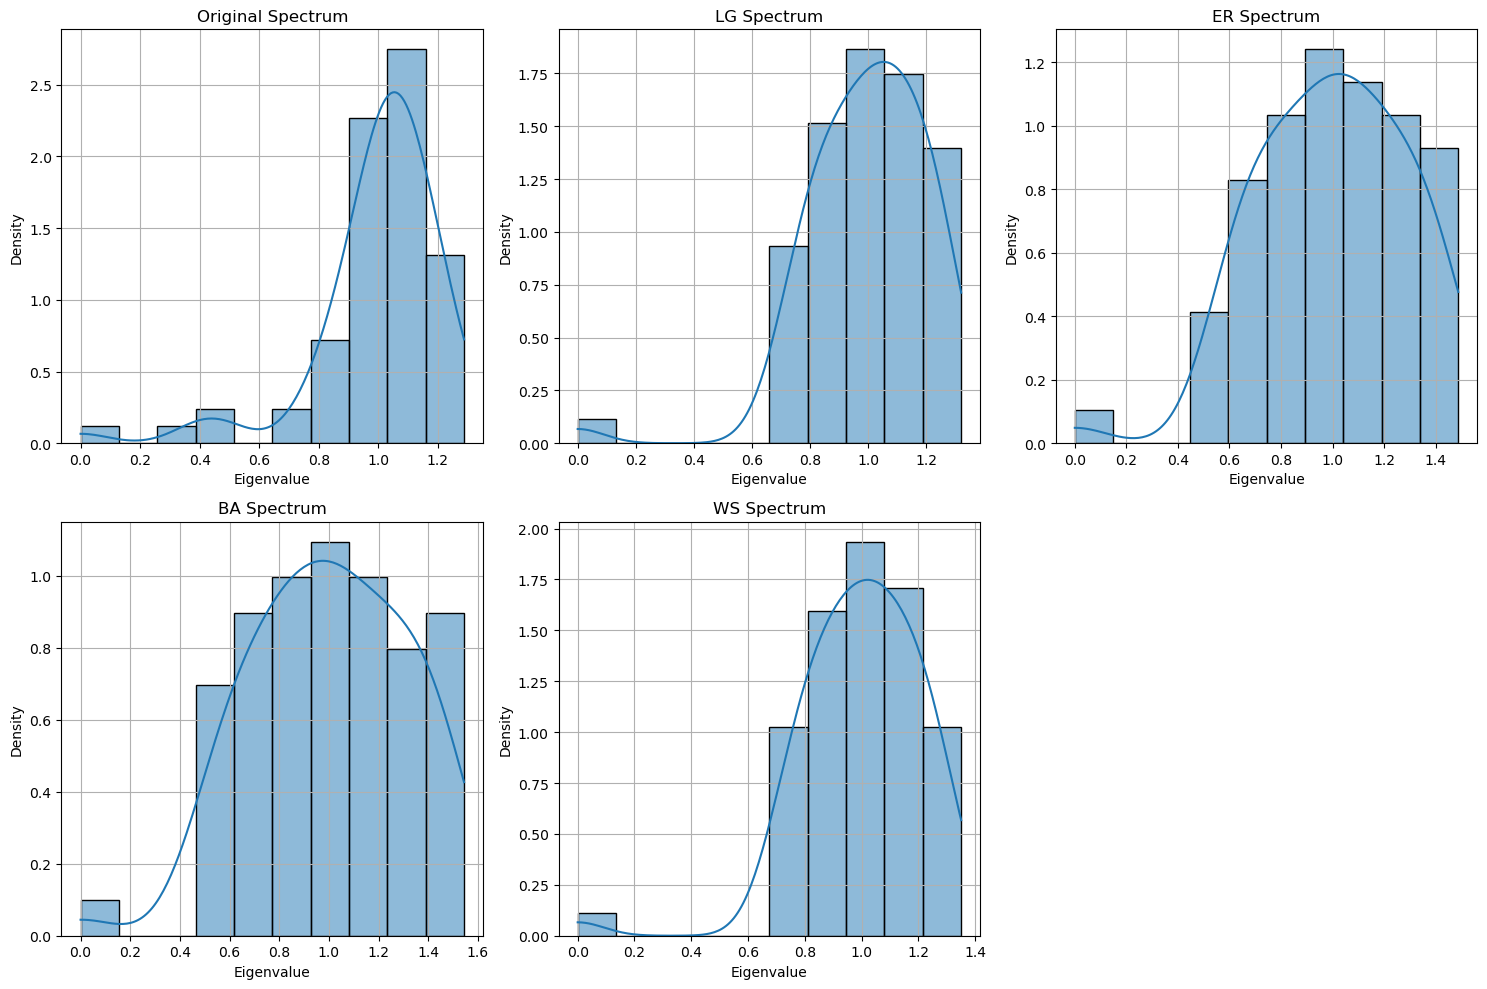

rhesus_cerebral.cortex_1


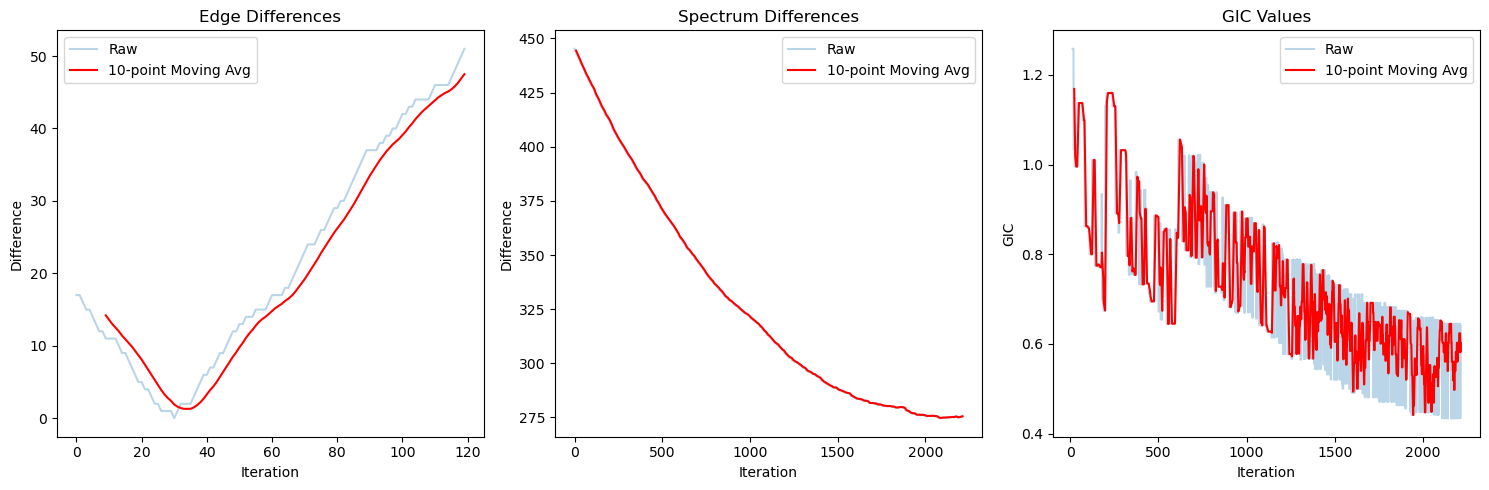

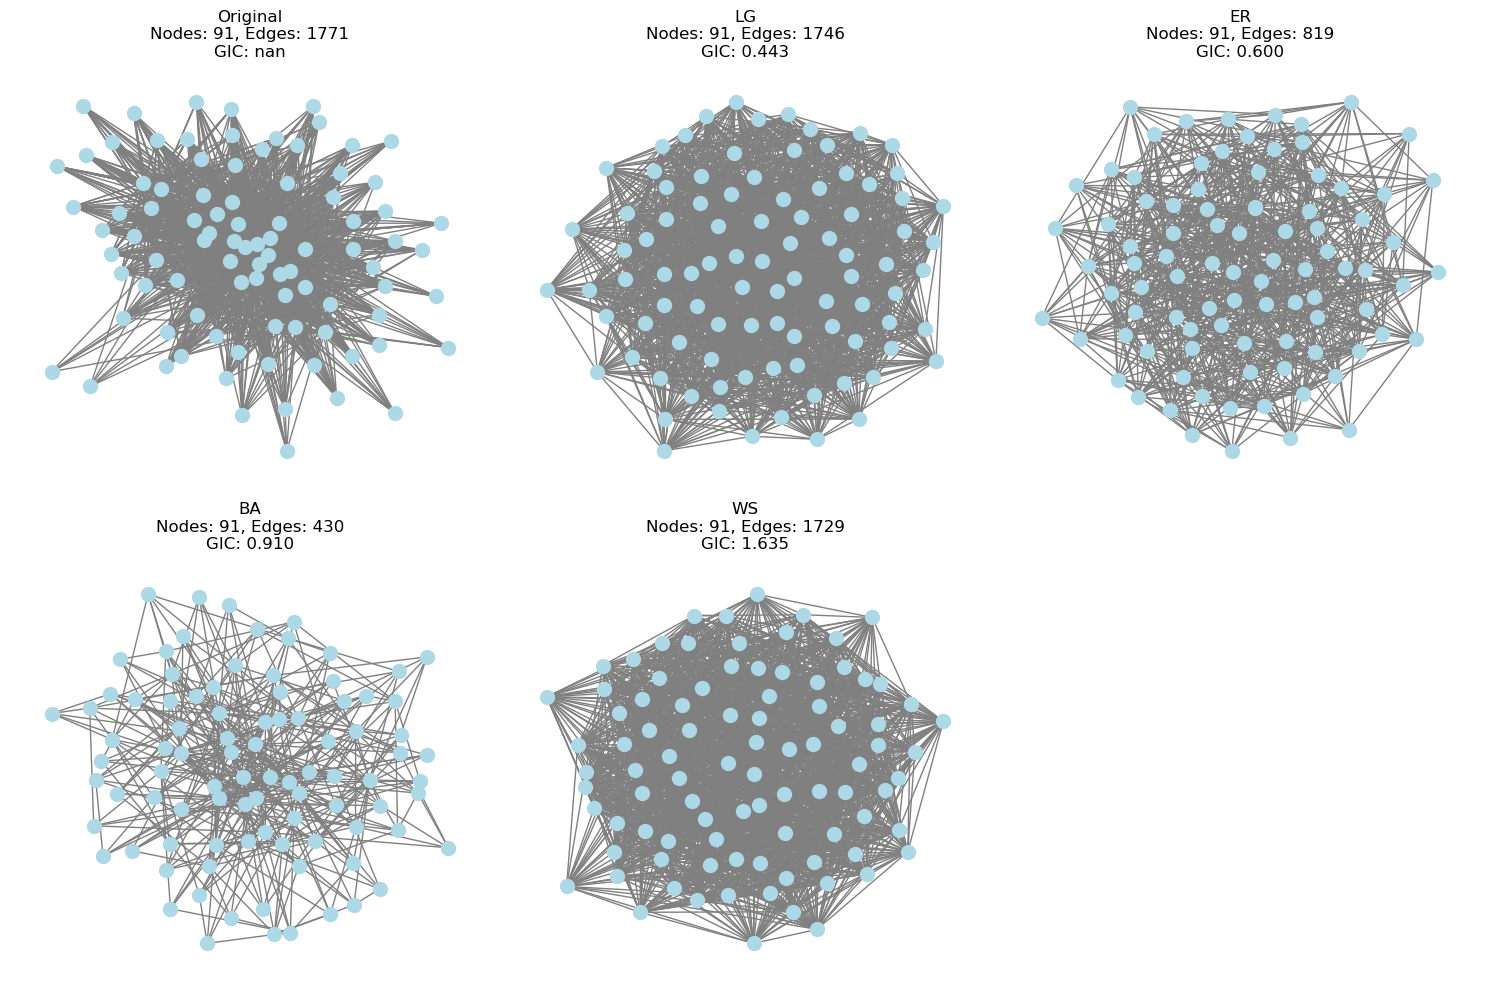

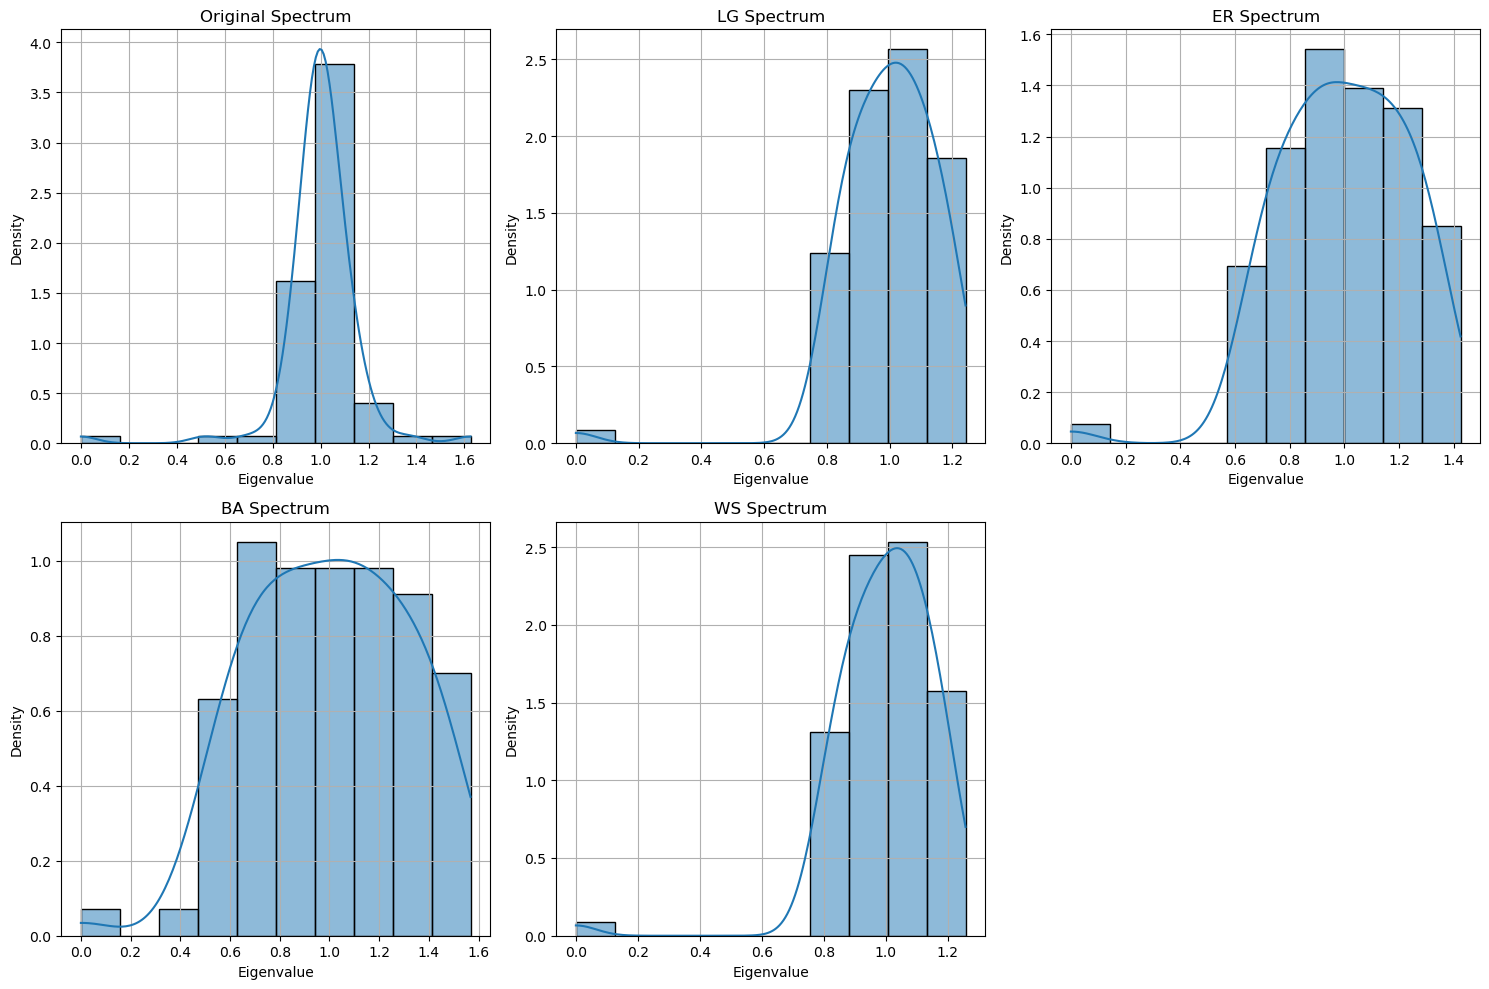

rhesus_brain_2


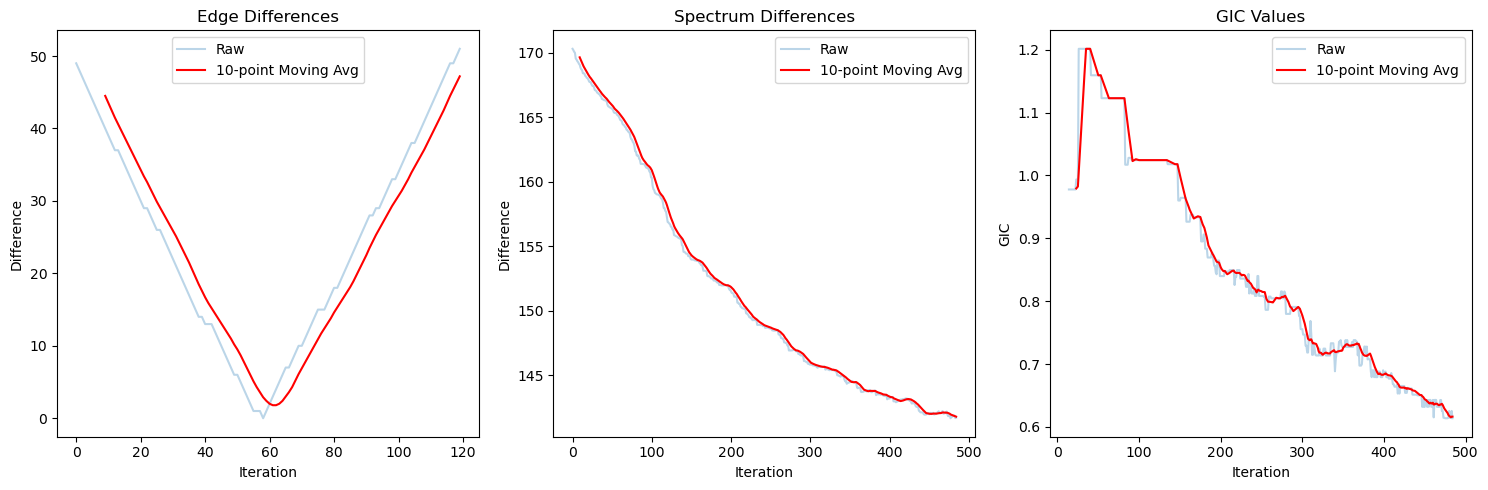

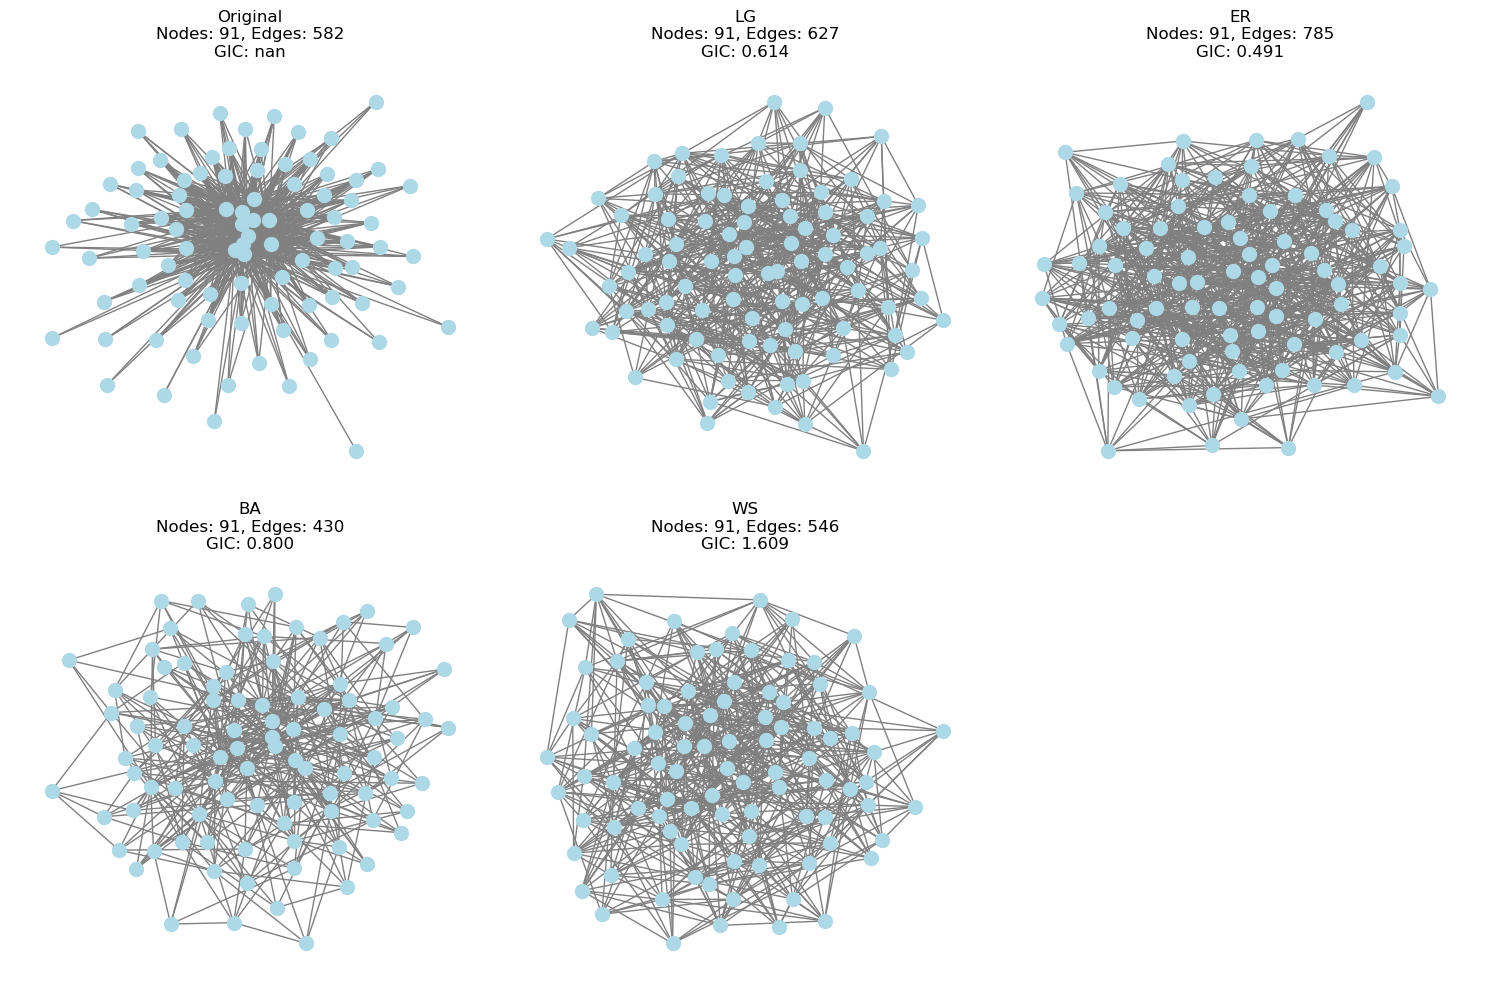

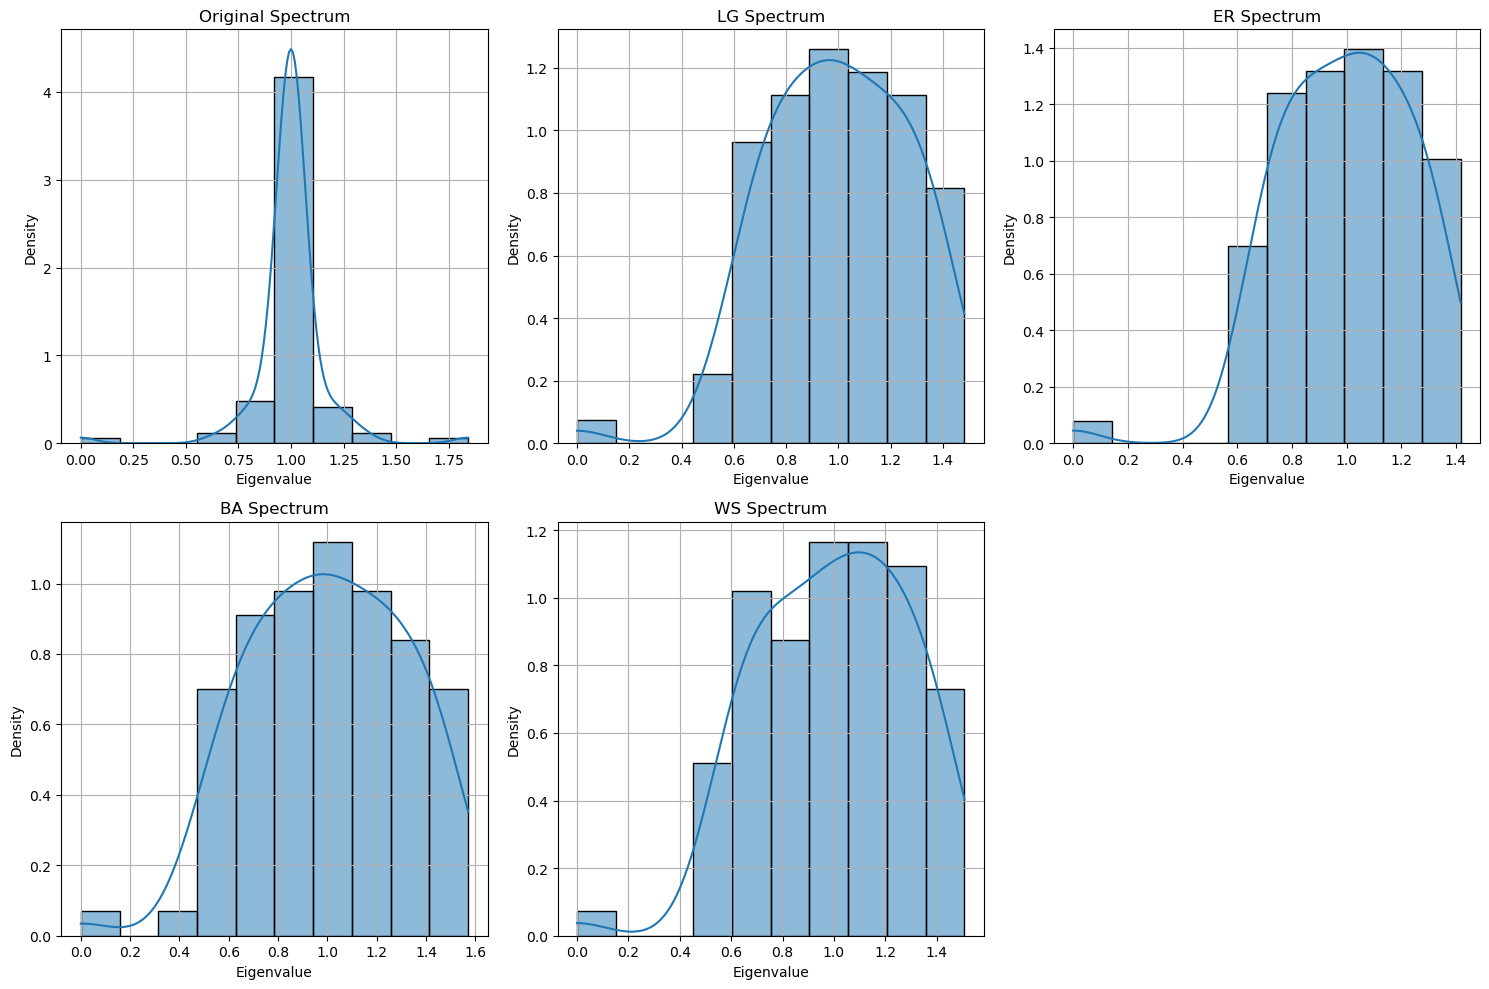

rhesus_interareal.cortical.network_2


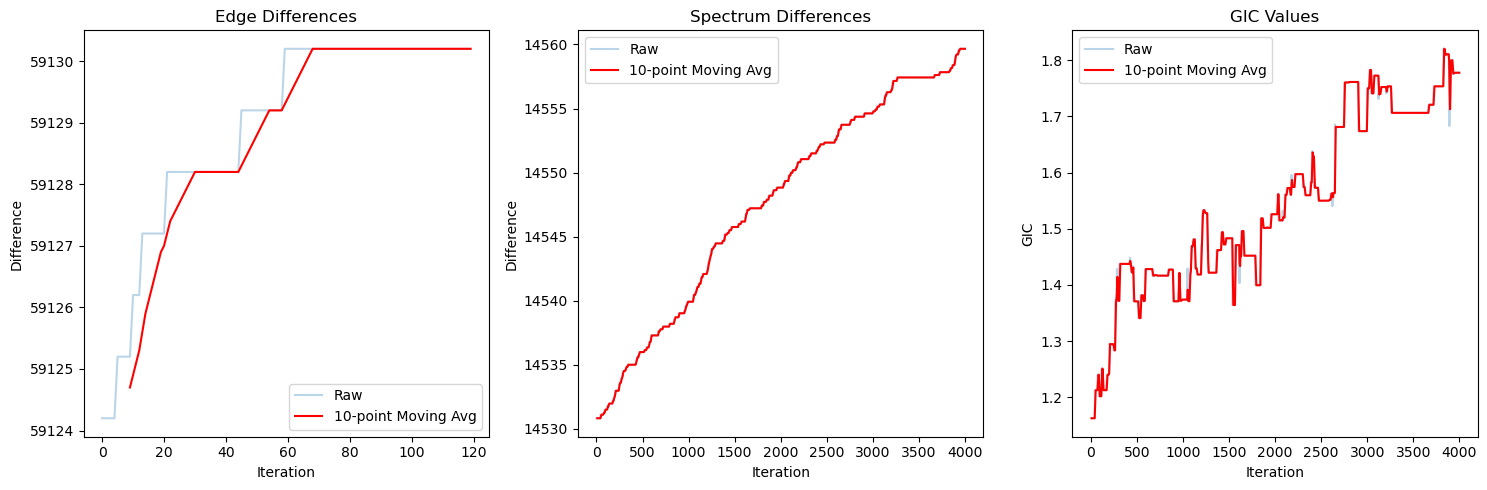

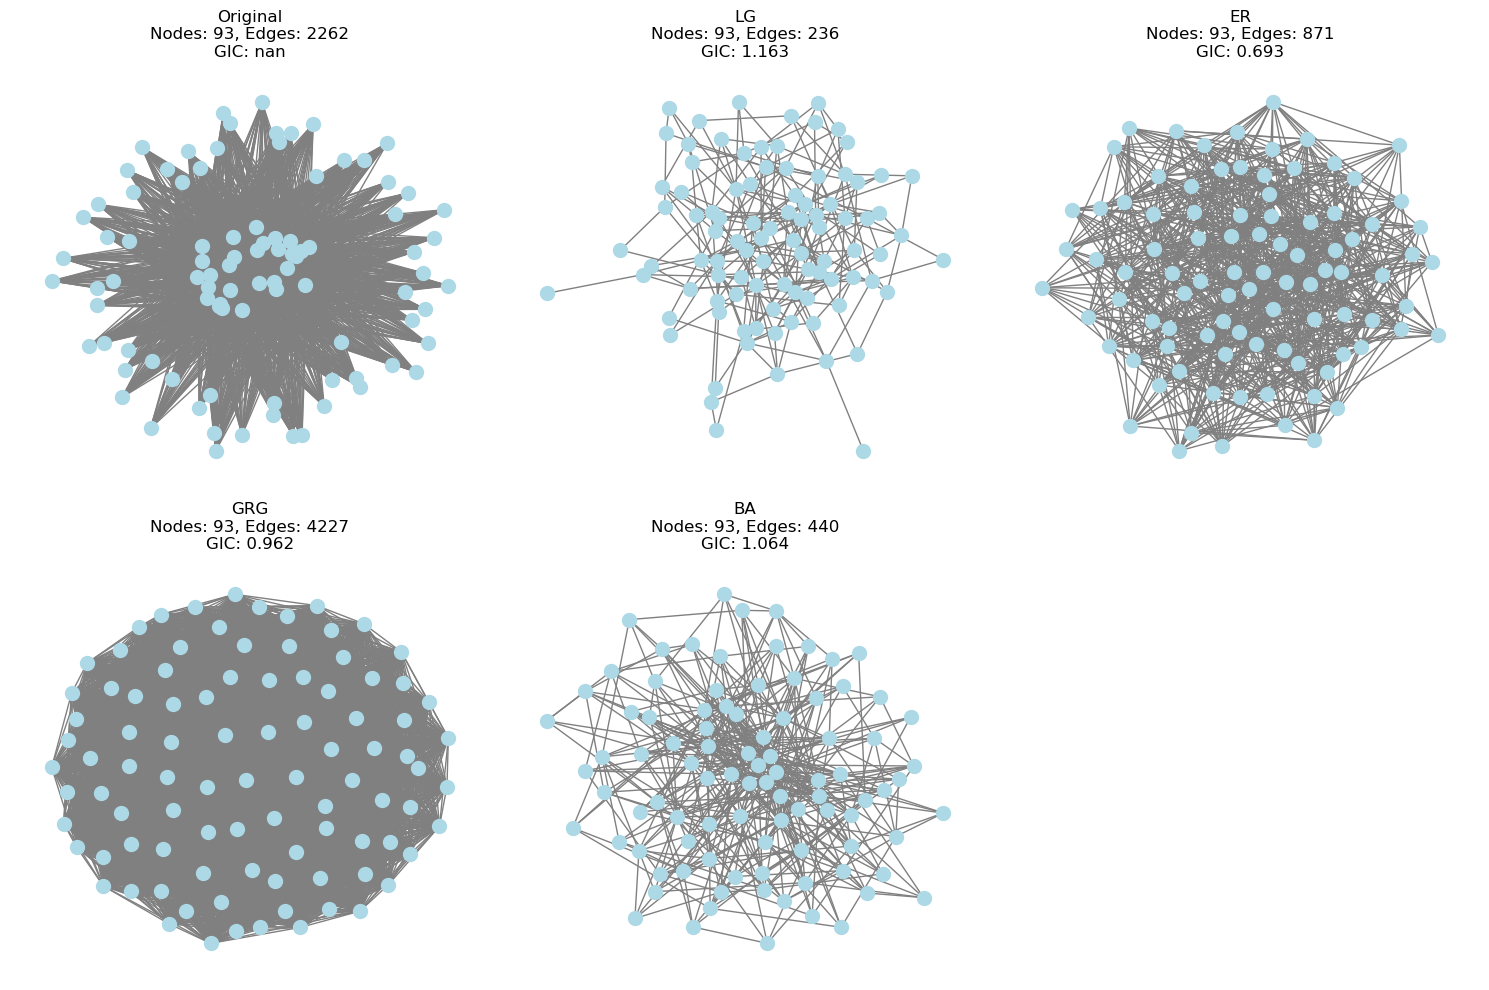

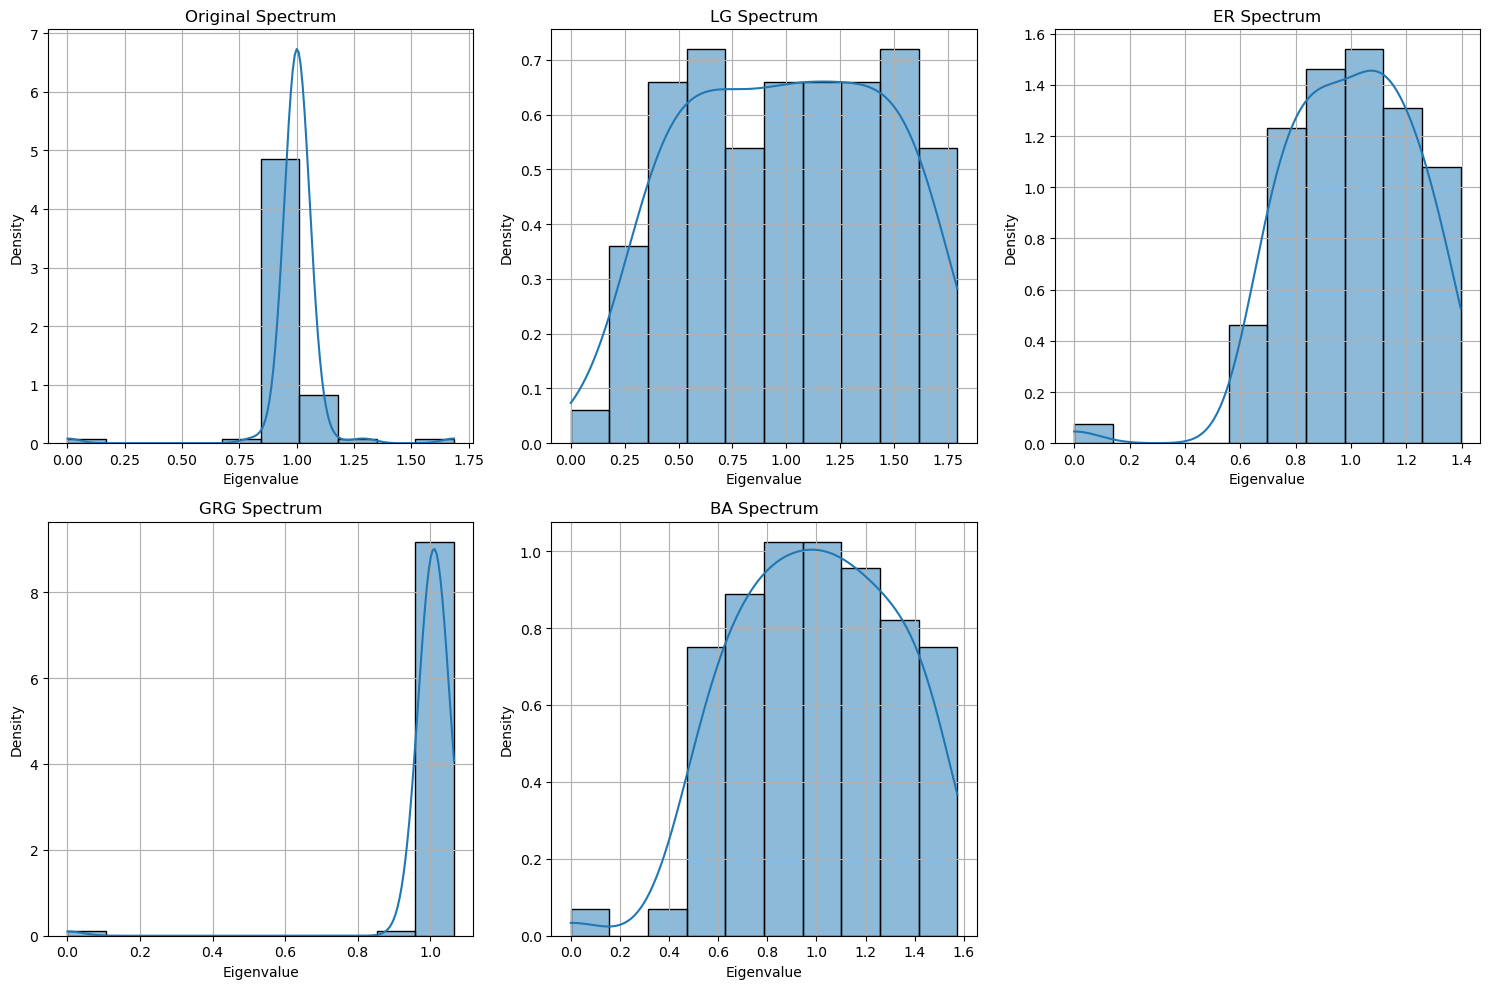

In [46]:
os.makedirs(f'imgs', exist_ok=True)
for i in range(len(comparators)):
    graph = comparators[i]
    graph_name = graph.summary_df['graph_filename'].iloc[0]
    graph_name = graph_name.replace('.graphml', '')
    print(graph_name)

    #graph = find_comparator_for_connectome('rhesus_cerebral.cortex_1.graphml')
    os.makedirs(f'imgs', exist_ok=True)
    spec_diff = graph.fitted_graphs_data['LG']['metadata']['spectrum_diffs']
    edge_diff = graph.fitted_graphs_data['LG']['metadata']['edge_diffs']
    gic_values = graph.fitted_graphs_data['LG']['metadata']['gic_values']

    # Calculate moving averages with window size of 10
    window = 10
    edge_diff_ma = pd.Series(edge_diff).rolling(window=window).mean()
    spec_diff_ma = pd.Series(spec_diff).rolling(window=window).mean()
    gic_values_ma = pd.Series(gic_values).rolling(window=window).mean()

    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.plot(edge_diff, alpha=0.3, label='Raw')
    plt.plot(edge_diff_ma, 'r-', label=f'{window}-point Moving Avg')
    plt.title('Edge Differences')
    plt.xlabel('Iteration')
    plt.ylabel('Difference')
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(spec_diff, alpha=0.3, label='Raw')
    plt.plot(spec_diff_ma, 'r-', label=f'{window}-point Moving Avg')
    plt.title('Spectrum Differences')
    plt.xlabel('Iteration')
    plt.ylabel('Difference')
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(gic_values, alpha=0.3, label='Raw')
    plt.plot(gic_values_ma, 'r-', label=f'{window}-point Moving Avg')
    plt.title('GIC Values')
    plt.xlabel('Iteration')
    plt.ylabel('GIC')
    plt.legend()

    plt.tight_layout()

    # Save the figure
    plt.savefig(f'imgs/{graph_name}_iteration.png', bbox_inches='tight', dpi=300)

    plt.show()
    # Get the graph data for each model
    graph_data = graph.fitted_graphs_data

    # Create a figure with subplots for each model
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Plot each graph
    for i, (model, data) in enumerate(graph_data.items()):
        graph2 = data['graph']
        pos = nx.spring_layout(graph2, seed=42)
        
        nx.draw(graph2, pos, ax=axes[i], 
                node_size=100,
                node_color='lightblue',
                edge_color='gray',
                with_labels=False)
        
        # Add title with model name and key metrics
        attrs = data['attributes']
        gic = data['metadata'].get('gic_value', 'N/A')
        title = f"{model}\n"
        title += f"Nodes: {attrs['nodes']}, Edges: {attrs['edges']}\n"
        # title += f"Density: {attrs['density']:.2f}\n"
        # title += f"Avg Clustering: {attrs['avg_clustering']:.2f}\n"
        title += f"GIC: {gic:.3f}" if isinstance(gic, float) else f"GIC: {gic}"
        axes[i].set_title(title)

    # Remove extra subplot
    axes[-1].remove()

    plt.tight_layout()

    # Save the figure
    plt.savefig(f'imgs/{graph_name}_graph.png', bbox_inches='tight', dpi=300)

    plt.show()
    # Get the graph data for each model
    graph_data = graph.fitted_graphs_data

    # Create a figure with subplots for each model
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Plot spectrum for each graph
    for i, (model, data) in enumerate(graph_data.items()):
        graph = data['graph']
        
        try:
            # Calculate eigenvalues
            L = nx.normalized_laplacian_matrix(graph)
            eigenvalues = np.linalg.eigvals(L.toarray())
            eigenvalues = np.real(eigenvalues)  # Get real parts
            
            # Plot histogram and KDE with reduced number of bins
            sns.histplot(data=eigenvalues, kde=True, ax=axes[i], stat='density', bins=10)
            axes[i].set_title(f"{model} Spectrum")
            axes[i].set_xlabel("Eigenvalue")
            axes[i].set_ylabel("Density")
            axes[i].grid(True)
        except MemoryError:
            axes[i].text(0.5, 0.5, "Memory Error", ha='center', va='center')
            axes[i].set_title(f"{model} Spectrum (Failed)")

    # Remove extra subplot
    axes[-1].remove()

    plt.tight_layout()

    # Save the figure
    plt.savefig(f'imgs/{graph_name}_spectrum.png', bbox_inches='tight', dpi=300)

    plt.show()

